In [451]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
#import keras
import matplotlib.pyplot as plt

from subprocess import check_output
print(check_output(["ls", "../Data"]).decode("utf8"))


data_dictionary.txt
macro.csv
macro.xlsx
sample_submission.csv
test.csv
train.csv
train.xlsx



In [452]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable

In [453]:
import math
import datetime
from sklearn.preprocessing import LabelEncoder

In [454]:
# Загружаем данные. Индексом ставим timestamp.

In [455]:
macro = pd.read_csv('../Data/macro.csv',index_col=['timestamp'], parse_dates=['timestamp'], dayfirst=True)
train = pd.read_csv('../Data/train.csv',index_col=['timestamp'], parse_dates=['timestamp'], dayfirst=True)
test = pd.read_csv('../Data/test.csv',index_col=['timestamp'], parse_dates=['timestamp'], dayfirst=True)

In [456]:
macro.shape, train.shape, test.shape

((2484, 99), (30471, 291), (7662, 290))

In [457]:
# Обьединение macro & train, macro & test
ntrain, ntest = pd.concat([train,macro],axis=1,join='inner'), pd.concat([test,macro],axis=1,join='inner')

print('macro=',macro.index.min(),macro.index.max())
print('train=',train.index.min(),train.index.max())
print('test =',test.index.min(),test.index.max())
print 'macro=', macro.shape, 'ntrain=', ntrain.shape, 'ntest=', ntest.shape

('macro=', Timestamp('2010-01-01 00:00:00'), Timestamp('2016-10-19 00:00:00'))
('train=', Timestamp('2011-08-20 00:00:00'), Timestamp('2015-06-30 00:00:00'))
('test =', Timestamp('2015-07-01 00:00:00'), Timestamp('2016-05-30 00:00:00'))
macro= (2484, 99) ntrain= (30471, 390) ntest= (7662, 389)


In [458]:
# Очистка данных (пока в процессе продумывания)

In [459]:
def clear_datas (data) :
    
    # clear life_sq
    data['life_sq'].dropna(0);
    
    while (data.life_sq.loc[(data.life_sq>90) & (data.life_sq>data.full_sq)].count()>0) :
        data.life_sq.loc[(data.life_sq>90) & (data.life_sq>data.full_sq)] /= 10.0;

    iid = data[data.life_sq>data.full_sq].index
    data.ix[iid,'life_sq'] = data.ix[iid,'full_sq'];
    
    data.loc[(data.kitch_sq>1000)|(data.kitch_sq>data.life_sq)] = np.NAN
    
    return

In [460]:
# Убираем индекс, переходим на нумерацию для простоты
ntrain = ntrain.reset_index()
ntest  = ntest.reset_index()
dict_col_le = {}

In [461]:
# Сериализация символьных значений

In [462]:
for cc in ntrain.select_dtypes(exclude=['int64', 'float64','datetime64']).columns :
    
    # Добиваем пустоты в колонке
    ntrain[cc] = ntrain[cc].fillna('NANA')
    ntest[cc]  = ntest[cc].fillna('NANA')
    
    le = LabelEncoder()
    # Заполняем класс значениями
    le.fit(list(ntrain[cc].values.astype('str')) + list(ntest[cc].values.astype('str')))
    # Перегоняем и сохраняем в словаре для будущего
    ntrain[cc] = le.transform(list(ntrain[cc].values.astype('str')))
    ntest[cc]  = le.transform(list(ntest[cc].values.astype('str')))
    
    #print(cc,le.classes_)
    dict_col_le[cc] = le
    
# Добиваем пустоты
ntrain=ntrain.fillna(0)
ntest =ntest.fillna(0)    

In [463]:
dict_col_le.keys()
#ntrain.child_on_acc_pre_school.unique()
#ntest.child_on_acc_pre_school.unique()
#dict_col_le['sub_area'].inverse_transform(ntrain.sub_area.unique())

['railroad_terminal_raion',
 'oil_chemistry_raion',
 'culture_objects_top_25',
 'product_type',
 'sub_area',
 'modern_education_share',
 'incineration_raion',
 'detention_facility_raion',
 'thermal_power_plant_raion',
 'radiation_raion',
 'old_education_build_share',
 'railroad_1line',
 'ecology',
 'big_market_raion',
 'water_1line',
 'nuclear_reactor_raion',
 'big_road1_1line',
 'child_on_acc_pre_school']

In [464]:
# Дополнение train полями usd, eur и расчет дополнительных результативных полей в train (стоимость м2 в usd и eur для жилой и общей площади)

In [465]:
def add_datetime (data) :
    data['day']     = data.timestamp.dt.day  
    data['month']   = data.timestamp.dt.month
    data['year']    = data.timestamp.dt.year
    data['week']    = data.timestamp.dt.week
    data['weekday'] = data.timestamp.dt.weekday
    return

def add_features_1 (data) :
    
    #data = data.reset_index()
    
    data['build_year0']   = data.build_year; 
    data.build_year0.loc[data.build_year<=1000]=data.year.loc[data.build_year<=1000]-1;
    
    data['full0']         = data.full_sq; data.full0.loc[data.full_sq==0]=1.0
    data['life0']         = data.life_sq; data.life0.loc[data.life_sq==0]=data.full0.loc[data.life_sq==0]; 
    data.life0.loc[data.life_sq>data.full_sq] = data.full0.loc[data.life_sq>data.full_sq]
    
    data['floor0']        = data.floor;     data.floor0.loc[data.floor<1]=1.0;
    data['max_floor0']    = data.max_floor; 
    data.max_floor0.loc[data.max_floor0<data.floor0]=data.floor0.loc[data.max_floor0<data.floor0];
    
    data.kitch_sq.loc[data.kitch_sq>data.life0] = data.life0.loc[data.kitch_sq>data.life0]
    
    data.num_room.loc[data.num_room<1] = 1
    
    data['floor:max']     = data.floor0/data.max_floor0  
    data['max-floor']     = data.max_floor0-data.floor0
    data['kitch:full']    = data.kitch_sq/data.full0 #/data.kitch_sq.median()
    data['life:full']     = data.life0/data.full0
    data['full:room']     = data.full0/data.num_room #/data.full0.median()
    data['life:room']     = data.life0/data.num_room
    data['full-life']     = data.full0-data.life0
    data['build-year']    = data.build_year0-data.year
    
    #data = data.set_index('timestamp')
    
    return(data)


In [511]:
ttrain, ttest = ntrain.copy(), ntest.copy();

add_datetime(ttrain)
add_datetime(ttest)

add_features_1(ttrain)
add_features_1(ttest)

ttrain['usd']=ttrain.price_doc/ttrain.usdrub; 
ttrain['eur']=ttrain.price_doc/ttrain.eurrub

ttrain['usdm2full'] = ttrain.usd/(ttrain.full0)
ttrain['usdm2life'] = ttrain.usd/(ttrain.life0)

ttrain['eurm2full'] = ttrain.eur/(ttrain.full0)
ttrain['eurm2life'] = ttrain.eur/(ttrain.life0)

#ttrain['full_life'], ttest['full_life'] = (ttrain.full_sq+1)/(ttrain.life_sq+1), (ttest.full_sq+1)/(ttest.life_sq+1)

ttrain['div_eurrub'],  ttest['div_eurrub']  = 1/ttrain.eurrub, 1/ttest.eurrub
ttrain['div_usdrub'],  ttest['div_usdrub']  = 1/ttrain.usdrub, 1/ttest.usdrub
ttrain['div_eurrub2'], ttest['div_eurrub2'] = ttrain.div_eurrub**2, ttest.div_eurrub**2
ttrain['div_usdrub2'], ttest['div_usdrub2'] = ttrain.div_usdrub**2, ttest.div_usdrub**2

coef = 1.0 # 0.969

###ttrain['r']    = np.log1p(ttrain.price_doc) # 2017-05-31 LB = 0.86
###ttrain['r']    = np.log1p(ttrain.usdm2full) # 2017-06-02 LB = 0.51
###ttrain['r']    = ttrain.usdm2full # 2017-06-02 LB = 0.361
###ttrain['r'] = ttrain.price_doc/(ttrain.full_sq+1.0) # # 2017-06-02 LB = 0.41066
##ttrain['r'] = ttrain.usdm2life # # 2017-06-02 LB = 0.37543
#######################################################################################################
ttrain['r'] = ttrain.usdm2full*coef 

llist = range(5,15)+range(25,35)+range(55,65)+range(85,95)+range(115,125)+range(145,155)+range(175,185)
xxrain = (pd.concat([macro.usdrub.shift(i) for i in llist], axis=1,keys=['L%s' % i for i in llist])).dropna()

ttrain = ttrain.set_index('timestamp')
ttest  = ttest.set_index('timestamp')

ttrain = pd.concat([ttrain,xxrain],axis=1,join='inner')
ttest  = pd.concat([ttest,xxrain], axis=1,join='inner')

ttrain = ttrain.reset_index()
ttest  = ttest.reset_index()

print(train.shape,ttrain.shape,test.shape,ttest.shape,xxrain.shape) #,llist)
ttrain.head()

((30471, 291), (30471, 490), (7662, 290), (7662, 482), (2297, 70))


,timestamp,id,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,L175,L176,L177,L178,L179,L180,L181,L182,L183,L184
0,2011-08-20,1,43,27.0,4.0,0.0,0.0,0.0,1.0,0.0,...,28.8913,28.8913,28.9957,29.1769,29.2807,29.1615,29.1666,29.1666,29.1666,29.2670
1,2011-08-23,2,34,19.0,3.0,0.0,0.0,0.0,1.0,0.0,...,28.7238,28.8705,28.8913,28.8913,28.8913,28.9957,29.1769,29.2807,29.1615,29.1666
2,2011-08-27,3,43,29.0,2.0,0.0,0.0,0.0,1.0,0.0,...,28.1741,28.1741,28.2145,28.3870,28.7238,28.8705,28.8913,28.8913,28.8913,28.9957
3,2011-09-01,4,89,50.0,9.0,0.0,0.0,0.0,1.0,0.0,...,28.5456,28.3738,28.2550,28.2416,28.1741,28.1741,28.1741,28.2145,28.3870,28.7238
4,2011-09-05,5,77,77.0,4.0,0.0,0.0,0.0,1.0,0.0,...,28.5080,28.6150,28.6150,28.6150,28.5456,28.3738,28.2550,28.2416,28.1741,28.1741


In [512]:
def bstImp (bst) :
    fff = bst.get_fscore()
    fff = pd.DataFrame(fff.values(),index=fff.keys(),columns=['imp'])
    ffs = fff.sort_values('imp')
    return(ffs)

ffs = bstImp(bstCV)
#ffs.tail(50)
#ffs.head(100)

In [513]:
#ffs.ix['full0']
#train['full0'].head()

In [514]:
#ffs.ix['div_usdrub']
#train_x[['div_usdrub','div_usdrub2']].head()

In [515]:
# Начинаем строить модель по остаткам train данных

In [952]:
# 2017-06-07 Поля на выброс после оценки
len(listOut1),len(resXsort), resXsort, listOut1
listOut1=ttrain.columns.values.tolist()
len(listOut1)
listOut1=listOut1[200:300]

In [998]:
col_res     = ['r'];
col_notuse  = ['usdm2full','usdm2life','eurm2full','eurm2life','price_doc','id','eur','usd','timestamp']+col_res
##col_notuse += ['full_sq', 'life_sq', 'floor', 'max_floor', 'build_year']

### begin 2017-06-04 after

col_notuse += ['build_year0','max_floor0', 'full0'] #, 'life0']  #, 'floor0']
#######col_notuse += ['usdrub','eurrub'] 
col_notuse += ['life_sq','floor','full0']

col_notuse += ['material'] #'build-year'] 

### -----------------------------------------------------------------------
# 2017-06-07

##col_notuse += listOut1
##col_notuse += ['state','kitch_sq']

### -----------------------------------------------------------------------

col_notuse += [ntrain.columns[i] for i in range(0,len(ntrain.columns)) if ntrain.dtypes[i]=='O']
col_notuse += [ntrain.columns[i] for i in range(0,len(ntrain.columns)) if len(ntrain[ntrain.columns[i]].unique())<=1]

col_use    = [ x for x in ttrain.columns.tolist() if x not in col_notuse];

train_x = ttrain[col_use+col_res]
train_x = ttrain[ttrain.timestamp>='2014'][col_use+col_res] ### 2017-06-07
#train_x['r']    = np.log1p(train_x.price_doc)

train_x = train_x.dropna()
train_y = train_x[col_res]
train_x = train_x[col_use]

test_x  = ttest[col_use]

print train.shape, train_x.shape, test.shape, test_x.shape

(30471, 291) (16901, 474) (7662, 290) (7662, 474)


In [999]:
print len(train),len(train_x)

30471 16901


In [1000]:
import xgboost as xgb

def rmsle(preds, dtrain):
    labels = dtrain.get_label()
    assert len(preds) == len(labels)
    preds_ = np.abs(preds)
    logs   = np.log1p(labels)-np.log1p(preds_)
    logs2  = np.sqrt((logs*logs).mean())
    return 'rmsle', logs2

def xgbtrain (param, train_x, train_y, num_round=1800, stopping=10, ratio=0.9) :
    
    split = int(round(ratio*len(train_y)))
    dtrain = xgb.DMatrix(train_x[:split],label=train_y[:split])
    dvalid = xgb.DMatrix(train_x[split:],label=train_y[split:])
    watchlist  = [(dtrain,'train'),(dvalid,'valid')]
    rvalid={}
    bst = xgb.train(param, dtrain, num_round, watchlist, evals_result=rvalid, early_stopping_rounds=stopping)
    return(bst,np.array(rvalid['valid']['rmse']))


In [1001]:
# Строим основные массивы
dtrain = xgb.DMatrix(train_x,label=train_y)
dtest  = xgb.DMatrix(test_x)

In [1002]:
if False :
    param = {'silent':0, 'objective':'reg:linear', 'eta':0.2, 'max_depth':19, 'subsample':0.7, 'colsample_bytree':0.99, 'metrics':'rmse'}
    ##param = {'silent':0, 'objective':'reg:linear', 'eta':0.02, 'max_depth':12, 'subsample':0.7, 'colsample_bytree':0.99, 'metrics':'rmse'}
    num_round = 1800 #300 # 300-the best , 1300 не дает эффекта

    print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M'))

    bst, rvalid_log = xgbtrain(param, train_x, train_y, num_round=num_round, stopping=30, ratio=0.9)

    train_g = bst.predict(dtrain,ntree_limit=rvalid_log.argmin())
    train_g = np.abs(train_g)
    _,train_rmsle = rmsle(train_g,dtrain)

    train_g = bst.predict(dtrain)
    train_g = np.abs(train_g)
    _,train_rmsle_full = rmsle(train_g,dtrain)

    print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M'), rvalid_log.argmin(), rvalid_log.min(), train_rmsle, train_rmsle_full)


In [1003]:
(range(1,5))

[1, 2, 3, 4]

In [1004]:
param = {'silent':0, 'objective':'reg:linear', 'eta':0.2, 'max_depth':19, 'subsample':0.7, 'colsample_bytree':0.99, 'metrics':'rmse'}
param = {'silent':0, 'objective':'reg:linear', 'eta':0.02, 'max_depth':12, 'subsample':0.7, 'colsample_bytree':0.99, 'metrics':'rmse'}
#param = {'silent':0, 'objective':'reg:linear', 'eta':0.02, 'max_depth':15, 'subsample':0.16, 'colsample_bytree':0.9399, 'metrics':'rmse'}
history = xgb.cv(param, dtrain, verbose_eval=10, metrics=['rmse'],feval=rmsle,num_boost_round=1500,nfold=5,early_stopping_rounds=20) #,stratified=True,maximize=True)

[0]	train-rmsle:3.8882+0.00324981	test-rmsle:3.91517+0.00902975
[10]	train-rmsle:1.60185+0.000642482	test-rmsle:1.6251+0.00715026
[20]	train-rmsle:1.06879+0.000315519	test-rmsle:1.10605+0.00521575
[30]	train-rmsle:0.789838+0.000494194	test-rmsle:0.842139+0.00353195
[40]	train-rmsle:0.618244+0.00122578	test-rmsle:0.686813+0.00373312
[50]	train-rmsle:0.505663+0.00171063	test-rmsle:0.590876+0.00567608
[60]	train-rmsle:0.429486+0.00208938	test-rmsle:0.531251+0.00762996
[70]	train-rmsle:0.377334+0.00248707	test-rmsle:0.494136+0.00950361
[80]	train-rmsle:0.341356+0.00282356	test-rmsle:0.471145+0.0110889
[90]	train-rmsle:0.316193+0.00320088	test-rmsle:0.457237+0.0124412
[100]	train-rmsle:0.298124+0.00302034	test-rmsle:0.44876+0.0135349
[110]	train-rmsle:0.285092+0.00316007	test-rmsle:0.443841+0.0144251
[120]	train-rmsle:0.274941+0.00363489	test-rmsle:0.441165+0.0151612
[130]	train-rmsle:0.266813+0.0037398	test-rmsle:0.439796+0.0156741
[140]	train-rmsle:0.260119+0.00375581	test-rmsle:0.43908+0

In [1005]:
dtrainCV = xgb.DMatrix(train_x,label=train_y)
watchlistCV  = [(dtrain,'train')]
rvalidCV = {}
bstCV = xgb.train(param, dtrainCV, history['test-rmsle-mean'].argmin()+2, watchlistCV, evals_result=rvalidCV, feval=rmsle)

train_cv = bstCV.predict(dtrainCV)
train_cv = np.abs(train_cv)
_,train_rmsle_CV = rmsle(train_cv,dtrainCV)

if False :
    bst, rvalid_log = xgbtrain(param, train_x, train_y, num_round=1800, stopping=30, ratio=0.9)

    train_cv = bst.predict(dtrainCV,ntree_limit=rvalid_log.argmin())
    train_cv = np.abs(train_cv)
    _,train_rmsle = rmsle(train_cv,dtrainCV)

[0]	train-rmsle:3.89106
[1]	train-rmsle:3.20261
[2]	train-rmsle:2.80869
[3]	train-rmsle:2.53259
[4]	train-rmsle:2.32015
[5]	train-rmsle:2.14955
[6]	train-rmsle:2.00773
[7]	train-rmsle:1.88577
[8]	train-rmsle:1.77933
[9]	train-rmsle:1.68624
[10]	train-rmsle:1.60282
[11]	train-rmsle:1.52734
[12]	train-rmsle:1.45897
[13]	train-rmsle:1.39628
[14]	train-rmsle:1.33859
[15]	train-rmsle:1.28541
[16]	train-rmsle:1.23601
[17]	train-rmsle:1.1902
[18]	train-rmsle:1.14734
[19]	train-rmsle:1.10722
[20]	train-rmsle:1.06951
[21]	train-rmsle:1.03427
[22]	train-rmsle:1.001
[23]	train-rmsle:0.969793
[24]	train-rmsle:0.939966
[25]	train-rmsle:0.911889
[26]	train-rmsle:0.885164
[27]	train-rmsle:0.859785
[28]	train-rmsle:0.835865
[29]	train-rmsle:0.813085
[30]	train-rmsle:0.791357
[31]	train-rmsle:0.770526
[32]	train-rmsle:0.750842
[33]	train-rmsle:0.731837
[34]	train-rmsle:0.713918
[35]	train-rmsle:0.696753
[36]	train-rmsle:0.680246
[37]	train-rmsle:0.664489
[38]	train-rmsle:0.649394
[39]	train-rmsle:0.634

(0.4388784, 157, 0.25079079999999998)


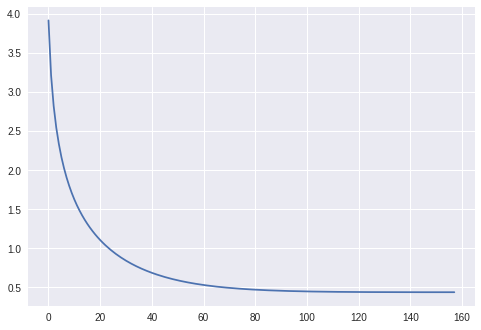

('cv=', 0.26323253, '(', 159, ')')


In [1006]:
print(history['test-rmsle-mean'].min(),history['test-rmsle-mean'].argmin(),history['train-rmsle-mean'][history['test-rmsle-mean'].argmin()])
plt.plot(history['test-rmsle-mean']); plt.show()

print('cv=',train_rmsle_CV, '(', history['test-rmsle-mean'].argmin()+2, ')') #,'train=',train_rmsle, '(', rvalid_log.argmin(), ')')

In [913]:
def vFeatures (param,train_x,train_y,col_ver,num_round=100) :
    res = []
    for icol in col_ver :
        try :
            train_x_s = train_x.copy()
            if len(icol)>0 :
                train_x_s = train_x_s.drop(icol,axis=1)
            #print(train_x_s.columns)
            dtrainCV = xgb.DMatrix(train_x_s,label=train_y)
            history = xgb.cv(param, dtrainCV, verbose_eval=10, metrics='rmse',num_boost_round=num_round,nfold=5,early_stopping_rounds=10)

            watchlistCV  = [(dtrainCV,'train')]
            rvalidCV = {}
            bstCV = xgb.train(param, dtrainCV, history['test-rmse-mean'].argmin()+2, watchlistCV, evals_result=rvalidCV)
            train_cv = bstCV.predict(dtrainCV)
            train_cv = np.abs(train_cv)
            _,train_rmsle_CV = rmsle(train_cv,dtrainCV)
            print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M'),icol,train_rmsle_CV)    
            res.append([icol,train_rmsle_CV])
        except :
            print(icol,'error')
        finally :
            pass
    return(res)
        
param = {'silent':0, 'objective':'reg:linear', 'eta':0.2, 'max_depth':19, 'subsample':0.7, 'colsample_bytree':0.99, 'metrics':'rmse'}
param = {'silent':0, 'objective':'reg:linear', 'eta':0.2, 'max_depth':12, 'subsample':0.7, 'colsample_bytree':0.99, 'metrics':'rmse'}

list1 = ['day', 'month', 'year', 'week', 'weekday']
list2 = ['build_year0','full0','life0','floor0','max_floor0','floor:max','max-floor','kitch:full','life:full','full:room','life:room','full-life','build-year']
list3 = ['div_usdrub','div_usdrub2','div_eurrub','div_eurrub2','usdrub','eurrub']
list4 = ['full_sq','life_sq','floor','max_floor','build_year']

listAll = train_x.columns.values.tolist()
listB = listAll[200:]
listE = listAll[:200]

listX = listAll[:20]

resX1 = vFeatures(param,train_x,train_y,['']+[listOut1])
#resB = vFeatures(param,train_x,train_y,['']+listB)
#resE = vFeatures(param,train_x,train_y,['']+listE)

[0]	train-rmse:7049.83+515.563	test-rmse:6810.97+2384.44
[10]	train-rmse:2121.58+328.263	test-rmse:3575.41+1724.88
[20]	train-rmse:1264.75+294.554	test-rmse:3429.82+1683.56
[0]	train-rmse:7012.76
[1]	train-rmse:5888.15
[2]	train-rmse:4979.77
[3]	train-rmse:4412.75
[4]	train-rmse:3799.58
[5]	train-rmse:3540.78
[6]	train-rmse:3308.76
[7]	train-rmse:2996.95
[8]	train-rmse:2672.39
[9]	train-rmse:2596.51
[10]	train-rmse:2524.17
[11]	train-rmse:2314.44
[12]	train-rmse:2116.49
[13]	train-rmse:1948.49
[14]	train-rmse:1885.17
[15]	train-rmse:1709.53
[16]	train-rmse:1569.99
[17]	train-rmse:1461.21
[18]	train-rmse:1416.35
[19]	train-rmse:1386.98
('2017-06-07 17:04', '', 0.36240777)
(['prom_part_5000', 'cafe_count_1500_price_4000', 'leisure_count_1500', 'green_part_5000', 'power_transmission_line_km', 'full:room', 'office_count_5000', 'cafe_count_1500_price_high', 'rent_price_1room_bus', 'income_per_cap', 'preschool_quota', 'L91', 'cafe_sum_3000_max_price_avg', 'L119', 'ID_bus_terminal', 'floor0',

In [915]:
resX
resX1
#resX = resX+resX1[1:]
len(resX1), len(resX)
resXsort = [x for x in resX if x[1]>resX[0][1]*0.995 and x[0] not in ['kitch_sq','life:full','life0','kitch_sq','week']]
resXsort = sorted(resXsort,key=lambda x: x[1])
listOut1 = [x[0] for x in resXsort]; 
len(listOut1),listOut1

(411,
 ['ice_rink_km',
  'ekder_female',
  'hospice_morgue_km',
  'cafe_count_5000_price_1000',
  'park_km',
  'cafe_sum_500_max_price_avg',
  'eurrub',
  'green_part_1000',
  'cafe_count_500_price_500',
  'big_market_km',
  'university_km',
  'ecology',
  'zd_vokzaly_avto_km',
  'mosque_count_5000',
  'L62',
  'L12',
  'L123',
  'trc_count_5000',
  'day',
  'office_sqm_500',
  'cafe_count_1500_price_1500',
  'cafe_count_3000_price_500',
  'average_provision_of_build_contract_moscow',
  'average_provision_of_build_contract',
  'L122',
  'L6',
  'cafe_count_2000_na_price',
  'mkad_km',
  'cafe_sum_3000_min_price_avg',
  'ID_railroad_station_avto',
  'L177',
  'state',
  'cafe_count_2000_price_1000',
  'sadovoe_km',
  'oil_chemistry_km',
  'office_count_500',
  'leisure_count_1000',
  'sport_count_3000',
  'radiation_km',
  'ID_metro',
  'L56',
  'L5',
  'trc_count_2000',
  'L58',
  'micex_cbi_tr',
  'deposits_growth',
  'area_m',
  'trc_sqm_2000',
  'load_of_teachers_preschool_per_teach

In [877]:
resXXsort = resX
resXXsort = sorted(resXXsort,key=lambda x: x[1],reverse=True)
##listOut1 = [x[0] for x in resXsort]; 
resXXsort

[['sport_objects_raion', 0.37185946],
 ['cemetery_km', 0.37157923],
 ['green_part_500', 0.37150562],
 ['cafe_count_1500', 0.37117377],
 ['trc_sqm_500', 0.37113219],
 ['big_church_count_1000', 0.37075922],
 ['L116', 0.37060791],
 ['indust_part', 0.37051281],
 ['preschool_education_centers_raion', 0.37046155],
 ['L149', 0.37040308],
 ['leisure_count_3000', 0.37037402],
 ['stadium_km', 0.37027431],
 ['rent_price_2room_eco', 0.37018549],
 ['cafe_count_3000_price_2500', 0.37009165],
 ['big_church_count_5000', 0.37001881],
 ['cafe_sum_5000_max_price_avg', 0.36998978],
 ['thermal_power_plant_raion', 0.36990732],
 ['oil_urals', 0.36990303],
 ['cafe_count_1500_price_2500', 0.36988041],
 ['ekder_male', 0.3698681],
 ['16_29_male', 0.36985916],
 ['trc_count_500', 0.36985049],
 ['ekder_all', 0.36984584],
 ['office_raion', 0.3698273],
 ['num_room', 0.36980423],
 ['0_17_female', 0.36976898],
 ['work_female', 0.36976674],
 ['raion_build_count_with_material_info', 0.3696976],
 ['children_preschool', 0.

In [205]:
for ii in rr : print ii

[0, 5, 640, 274, 0.49635800000000002, 427.69666, 12081.401]
[5, 10, 945, 425, 0.51961999999999997, 229.52989, 10759.421]
[10, 15, 1191, 170, 0.54957100000000003, 316.75485, 7137.3076]
[15, 20, 1246, 141, 0.57065200000000005, 449.70831, 198995.09]
[20, 25, 849, 151, 0.75849699999999998, 261.53488, 11820.343]
[25, 30, 1087, 198, 0.50190000000000001, 706.79462, 614535.12]
[30, 35, 1154, 184, 0.46602399999999999, 616.81488, 602978.81]
[35, 40, 1208, 221, 0.57780799999999999, 393.56015, 11680.995]
[40, 45, 1014, 141, 0.59879800000000005, 451.50348, 7749.8374]
[45, 50, 1226, 270, 0.55420400000000003, 376.20383, 9930.4365]
[50, 55, 846, 367, 0.54253200000000001, 355.76801, 356213.69]
[55, 60, 1371, 200, 0.49113800000000002, 378.98029, 13598.32]
[60, 65, 1535, 197, 0.48666199999999998, 311.78806, 271376.5]
[65, 70, 1463, 171, 0.27464100000000002, 497.04465, 297258.44]
[70, 75, 2670, 205, 0.23500599999999999, 379.76648, 305796.97]
[75, 80, 1194, 306, 0.47662300000000002, 258.436, 11435.91]
[80,

In [89]:
dict_col_le['sub_area'].inverse_transform(range(65,75)+range(85,105))

array(['Mitino', 'Molzhaninovskoe', "Moskvorech'e-Saburovo", 'Mozhajskoe',
       'Nagatino-Sadovniki', 'Nagatinskij Zaton', 'Nagornoe', 'Nekrasovka',
       'Nizhegorodskoe', 'Novo-Peredelkino', 'Pokrovskoe Streshnevo',
       'Poselenie Desjonovskoe', 'Poselenie Filimonkovskoe',
       'Poselenie Kievskij', 'Poselenie Klenovskoe',
       'Poselenie Kokoshkino', 'Poselenie Krasnopahorskoe',
       'Poselenie Marushkinskoe', 'Poselenie Mihajlovo-Jarcevskoe',
       'Poselenie Moskovskij', 'Poselenie Mosrentgen',
       'Poselenie Novofedorovskoe', 'Poselenie Pervomajskoe',
       'Poselenie Rjazanovskoe', 'Poselenie Rogovskoe',
       'Poselenie Shhapovskoe', 'Poselenie Shherbinka',
       'Poselenie Sosenskoe', 'Poselenie Vnukovskoe',
       'Poselenie Voronovskoe'], 
      dtype='|S30')

In [1007]:
# Строим результат

In [1008]:
dtest = xgb.DMatrix(test_x)
#test_p = bst.predict(dtest,ntree_limit=rvalid_log.argmin())
test_p = bstCV.predict(dtest)
#test_p = bst.predict(dtest)
test_p = np.abs(test_p)

In [1009]:
test_r = pd.DataFrame(ttest[['id']]); 
##test_r['price_doc']=np.expm1(test_p)*(test_x.full_sq+1)*test_x.usdrub # 2017-06-02 LB = 0.54
##test_r['price_doc'] = test_p*(test_x.full_sq+1)*test_x.usdrub; # 2017-06-02 LB = 0.361
##test_r['price_doc'] = test_p*(test_x.full_sq+1); # 2017-06-02 LB = 0.41066
##test_r['price_doc'] = test_p*(test_x.life_sq+1)*test_x.usdrub; # 2017-06-02 LB = 0.39

#test_r['price_doc'] = test_p*test_x.life0*test_x.usdrub; # 2017-06-02 LB = 0.37543
test_r['price_doc'] = test_p*ttest.full0*ttest.usdrub; # 2017-06-02 LB = 0.37296

print test_r.price_doc.min(),test_r.price_doc.max(),train.price_doc.min(),train.price_doc.max() 
test_r.head(8)
#test_r.tail(8)
#test_r.shape

1796291.45582 98371417.152 100000 111111112


,id,price_doc
0,30474,5.063244e+06
1,30475,8.745503e+06
2,30476,5.566817e+06
3,30477,5.956106e+06
4,30478,4.997005e+06
5,30479,9.597956e+06
6,30480,4.542531e+06
7,30481,4.281811e+06


In [1010]:
ntest[test_r.price_doc<0.0]

,timestamp,id,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,provision_retail_space_modern_sqm,turnover_catering_per_cap,theaters_viewers_per_1000_cap,seats_theather_rfmin_per_100000_cap,museum_visitis_per_100_cap,bandwidth_sports,population_reg_sports_share,students_reg_sports_share,apartment_build,apartment_fund_sqm


In [977]:
# Результат в файл

In [997]:
test_r[['id','price_doc']].to_csv('../Result/res-41.csv',index=False)

In [433]:
#history[:20]
xgb.__version__
#bst.__dict__

'0.6'

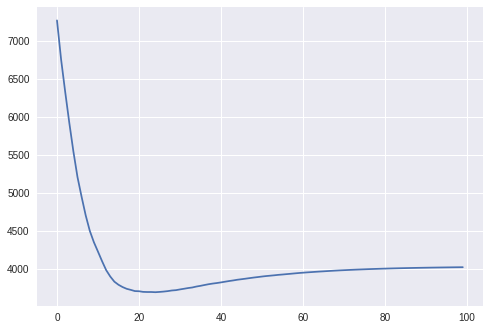

(3691.1898191999999, 24)


In [434]:
plt.plot(history['test-rmse-mean']); plt.show()
print(history['test-rmse-mean'].min(),history['test-rmse-mean'].argmin())

In [873]:
fff = bstCV.get_fscore()
fff = pd.DataFrame(fff.values(),index=fff.keys(),columns=['imp'])
ffs = fff.sort_values('imp')
ffs.tail(60)
#ffs.head(100)

,imp
ice_rink_km,311
ttk_km,314
big_church_km,317
ts_km,323
green_zone_part,324
radiation_km,326
raion_popul,330
workplaces_km,335
market_shop_km,338
bus_terminal_avto_km,339


In [83]:
print train_x.floor0.head(), '\n\n', len(ffs), len(train_x.columns)
ffs['imp'][['material','sub_area','life0','floor','floor0','max_floor0','max-floor','floor:max','max_floor','full0']]

timestamp
2011-08-20    4.0
2011-08-23    3.0
2011-08-27    2.0
2011-09-01    9.0
2011-09-05    4.0
Name: floor0, dtype: float64 

390 474


material       2431.0
sub_area       4460.0
life0          2637.0
floor         18546.0
floor0            NaN
max_floor0        NaN
max-floor      1537.0
floor:max      3558.0
max_floor      5971.0
full0             NaN
Name: imp, dtype: float64

In [103]:
ttrain[ttrain.max_floor0<ttrain.floor0][['floor','max_floor','floor0','max_floor0']].head()
#ttrain[ttrain.max_floor0<1][['floor','max_floor','floor0','max_floor0']].head()
#ttrain[0:10].life_sq.rank()
#pd.Series([0,0,0,0,1,1,1,1,1]).rank()
ttrain[['material']].describe()
pd.concat([pd.DataFrame(train.material.value_counts()/len(train)),pd.DataFrame(test.material.value_counts())/len(test)],axis=1)
ttrain.num_room.value_counts()
#ttrain[ttrain.kitch_sq>ttrain.life0][['kitch_sq','life0','full0']] #.count() #value_counts()
#ttrain[ttrain.num_room<1][['num_room','life0','full0']].head() #.count() #value_counts()
temp=ttrain.sub_area.value_counts()
#train.area_m.value_counts()
pd.DataFrame(temp).reset_index()['index'][:20].values.tolist()

[102.0,
 72.0,
 103.0,
 94.0,
 105.0,
 65.0,
 134.0,
 48.0,
 60.0,
 87.0,
 38.0,
 101.0,
 124.0,
 143.0,
 86.0,
 82.0,
 70.0,
 12.0,
 71.0,
 126.0]

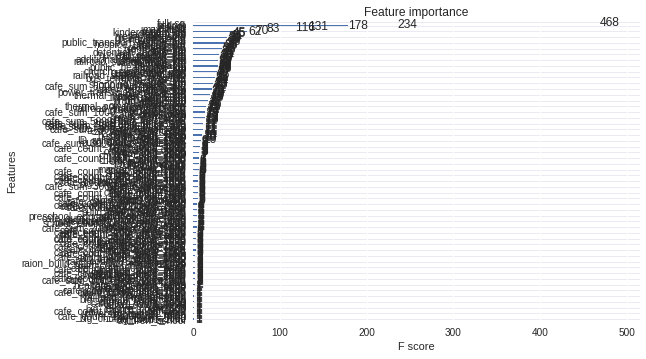

In [61]:
aax = plt.figure(figsize=(16, 16));
xgb.plot_importance(bst); 
#xgb.plot_tree(bst); 
plt.show()

In [8]:
temp=pd.DataFrame(ttrain.columns);

In [9]:
ttrain['sub_area'].unique()

array(['Bibirevo', 'Nagatinskij Zaton', "Tekstil'shhiki", 'Mitino',
       'Basmannoe', 'Nizhegorodskoe', "Sokol'niki", 'Koptevo', 'Kuncevo',
       'Kosino-Uhtomskoe', 'Zapadnoe Degunino', 'Presnenskoe', 'Lefortovo',
       "Mar'ino", "Kuz'minki", 'Nagornoe', "Gol'janovo", 'Vnukovo',
       'Juzhnoe Tushino', 'Severnoe Tushino', "Chertanovo Central'noe",
       'Fili Davydkovo', 'Otradnoe', 'Novo-Peredelkino', 'Bogorodskoe',
       'Jaroslavskoe', 'Strogino', 'Hovrino', "Moskvorech'e-Saburovo",
       'Staroe Krjukovo', 'Ljublino', 'Caricyno', 'Veshnjaki',
       'Danilovskoe', 'Preobrazhenskoe', "Kon'kovo", 'Brateevo',
       'Vostochnoe Izmajlovo', 'Vyhino-Zhulebino', 'Donskoe',
       'Novogireevo', 'Juzhnoe Butovo', 'Sokol', 'Kurkino', 'Izmajlovo',
       'Severnoe Medvedkovo', 'Rostokino', 'Orehovo-Borisovo Severnoe',
       'Ochakovo-Matveevskoe', 'Taganskoe', 'Dmitrovskoe',
       'Orehovo-Borisovo Juzhnoe', 'Teplyj Stan', 'Babushkinskoe',
       'Pokrovskoe Streshnevo', 'Obruc

In [7]:
print(' train=',train.index.min(),train.index.max())
print('ttrain=',ttrain.index.min(),ttrain.index.max())

(' train=', Timestamp('2011-08-20 00:00:00'), Timestamp('2015-06-30 00:00:00'))
('ttrain=', Timestamp('2011-08-20 00:00:00'), Timestamp('2015-06-30 00:00:00'))


In [183]:
acf,confint,qstat,pvalues = sm.tsa.stattools.acf(xtrain,nlags=600,alpha=0.05,qstat=True,fft=True)
#acf
confint.shape #[-10:]
#qstat[-10:]
#pvalues[-10:]
acf[acf>3*confint[:,0]]
#acf.shape, confint.shape
acf[177:185], confint[177:185], qstat[177:185], pvalues[177:185]

(array([ 0.05687618,  0.01495214,  0.01454301,  0.12218533,  0.01729215,
         0.01492026,  0.01349208,  0.01702206]),
 array([[ 0.04518074,  0.06857162],
        [ 0.00322188,  0.02668239],
        [ 0.00281035,  0.02627567],
        [ 0.1104504 ,  0.13392027],
        [ 0.00539791,  0.02918638],
        [ 0.00302285,  0.02681767],
        [ 0.00159232,  0.02539185],
        [ 0.00512036,  0.02892375]]),
 array([ 1404.55727916,  1411.04037485,  1868.68299746,  1877.84943322,
         1884.673916  ,  1890.25462559,  1899.13783036,  1903.71613167]),
 array([  1.93568353e-189,   3.20097876e-190,   2.63858406e-278,
          1.34856387e-279,   1.98803802e-280,   5.14158124e-281,
          2.98600922e-282,   1.21397189e-282]))